# Hate Crime ETL Project
## January 12, 2022
### Sakshi and Abbie

### Analysis of Hate Crimes in the United States

**Introduction and Background**

Hate crime statistics were downloaded from the Federal Bureau of Investigation (FBI) Crime Data Explorer (CDE). The data contain hate crimes reported between 1991 and 2020. All data are at the incident level. The FBI defines a hate crime as a crime that is "motivated in whole, or in part, by an offender’s bias against the victim’s perceived race, gender, gender identity, religion, disability, sexual orientation, or ethnicity."

**Project Objective**

The goal of this project was to insert our hate crime data into a postgres database through the use of psycopg2. After doing so, we were then able to execute a variety of SQL queries. Our process will be outlined below.


### Data Model

The data model below highlights how our two tables relate to each other: Incident and location. One location can have many incidents, as the diagram represents. Moreover, it is *required* that an incident also has a location associated with it. The incident_id column was used as the unique primary key for the incident table. For the location table, we used ORI and Location_Name, together, as the primary key. As expected, there are many more unique incidents, than there are unique locations. 

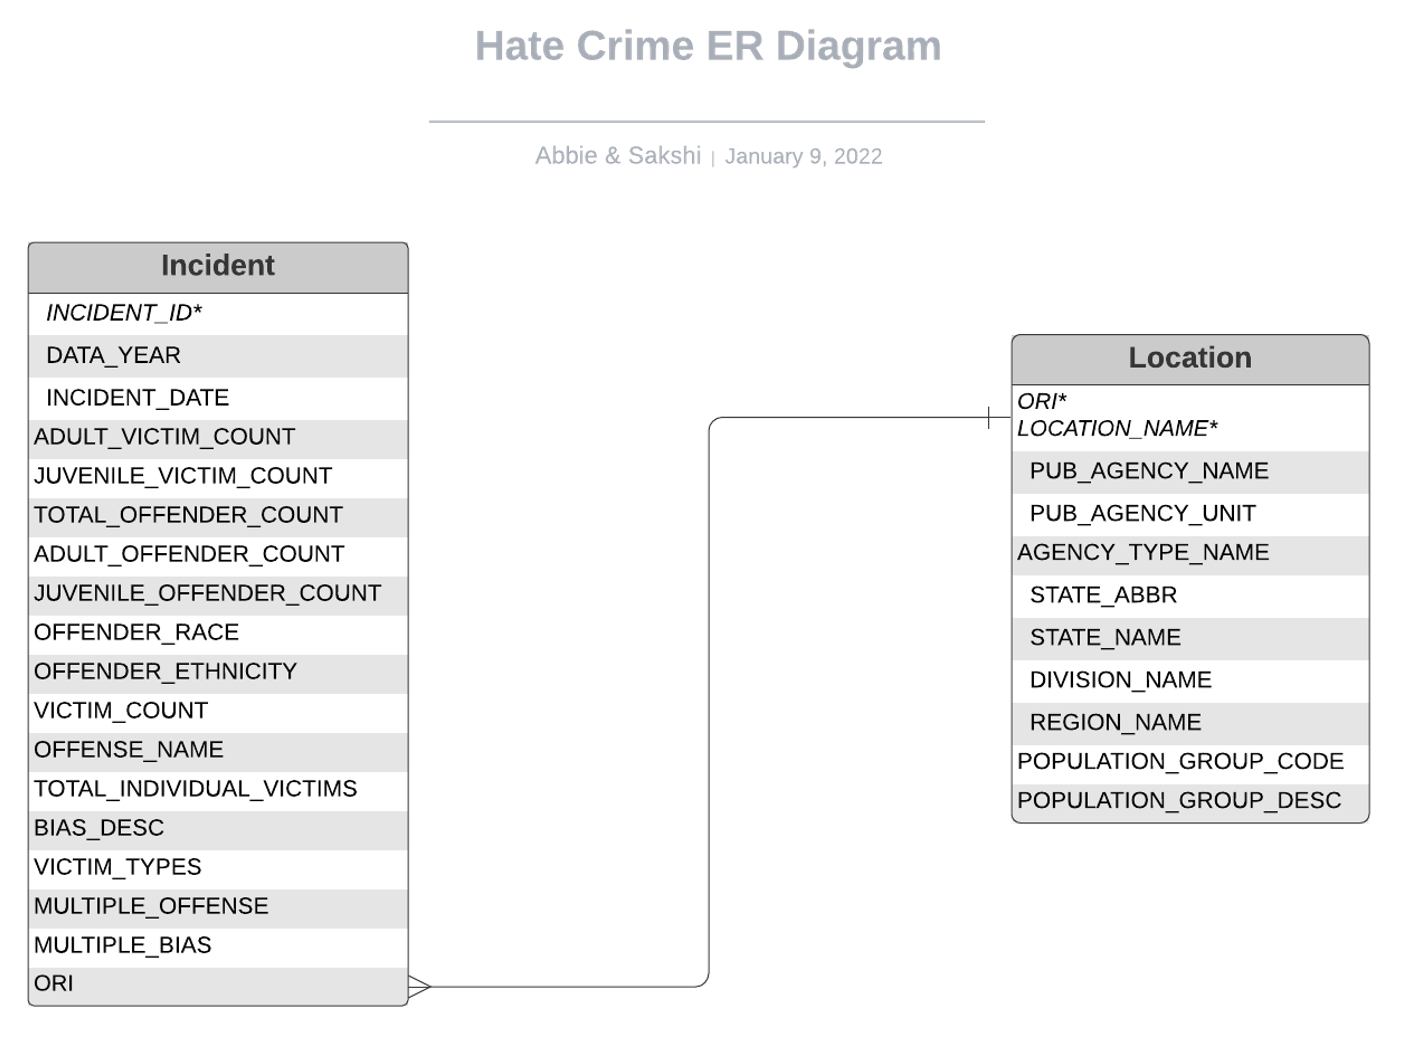

### Simple Pre-processing

After creating the data model, we loaded in the proper python modules, as well as our original csv file. In order to prepare the file for postgres, we had to complete some simple pre-processing, which will be explained below.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import psycopg2
# Import the .py file that I created to store my password
from passwords import password

In [2]:
# Import csv file from FBI CDE website
hate_crime = pd.read_csv("../Datasets/hate_crime.csv", low_memory=False)

# View data
hate_crime.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


Postgres did not interpret the NaNs from our file as null values. This would have negatively affected our integer data type for some variables. Because of this, we had to first replace those NaNs with 'None' type. 

In [3]:
# Fill in null values so that SQL will understand them
hate_crime = hate_crime.fillna(np.nan).replace([np.nan], [None])

Additionally, we needed to replace commas with empty spaces in some variables. This is because our file is comma delimmited. If we did *not* complete this step, postgres would have thought there were more columns than there actually were. This resolved that issue.

In [4]:
# Eliminate commas in certain variables. 
# so, sql will not be confused by the comma delimited and assume extra columns
hate_crime["BIAS_DESC"] = hate_crime["BIAS_DESC"].str.replace(","," ")
hate_crime["OFFENSE_NAME"] = hate_crime["OFFENSE_NAME"].str.replace(","," ")
hate_crime["POPULATION_GROUP_DESC"] = hate_crime["POPULATION_GROUP_DESC"].str.replace(","," ")
hate_crime["PUB_AGENCY_UNIT"] = hate_crime["PUB_AGENCY_UNIT"].str.replace(","," ")
hate_crime["PUB_AGENCY_NAME"] = hate_crime["PUB_AGENCY_NAME"].str.replace(","," ")

Finally, we were able to separate the data file into our two tables:
1) Incident

2) Location

**Incident Table**

In [5]:
# Separate the incident data
Incident_df = hate_crime[['INCIDENT_ID', 'DATA_YEAR', 'INCIDENT_DATE', 'ADULT_VICTIM_COUNT', 'JUVENILE_VICTIM_COUNT',
       'TOTAL_OFFENDER_COUNT', 'ADULT_OFFENDER_COUNT', 'JUVENILE_OFFENDER_COUNT', 'OFFENDER_RACE', 'OFFENDER_ETHNICITY',
       'VICTIM_COUNT', 'OFFENSE_NAME', 'TOTAL_INDIVIDUAL_VICTIMS', 'BIAS_DESC', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE',
       'MULTIPLE_BIAS', 'ORI']]
# View incident data
Incident_df.sort_values("INCIDENT_ID").head()

,INCIDENT_ID,DATA_YEAR,INCIDENT_DATE,ADULT_VICTIM_COUNT,JUVENILE_VICTIM_COUNT,TOTAL_OFFENDER_COUNT,ADULT_OFFENDER_COUNT,JUVENILE_OFFENDER_COUNT,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS,ORI
12,2,1991,15-JAN-91,None,None,0,None,None,Unknown,None,1,Intimidation,1.0,Anti-Black or African American,Individual,S,S,AZ0072300
13,3,1991,22-JAN-91,None,None,1,None,None,Unknown,None,1,Intimidation,1.0,Anti-Jewish,Individual,S,S,AZ0072300
14,4,1991,23-JAN-91,None,None,1,None,None,Unknown,None,1,Intimidation,1.0,Anti-Arab,Individual,S,S,AZ0072300
15,5,1991,04-FEB-91,None,None,1,None,None,White,None,1,Aggravated Assault,1.0,Anti-Black or African American,Individual,S,S,AZ0072300
16,6,1991,14-FEB-91,None,None,0,None,None,Unknown,None,1,Destruction/Damage/Vandalism of Property,0.0,Anti-Protestant,Religious Organization,S,S,AZ0072300


In [6]:
# Confirm the number of unique incident_ids, which is our primary key
Incident_df['INCIDENT_ID'].nunique()

219577

In [7]:
# Confirm that this value matches the number of rows
len(Incident_df.index)

219577

In [8]:
# Checking for datafram shape
Incident_df.shape

(219577, 18)

**Location Table**

In [9]:
# Separate the location data
Location_df = hate_crime[['ORI', 'LOCATION_NAME', 'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT', 'AGENCY_TYPE_NAME',
       'STATE_ABBR', 'STATE_NAME', 'DIVISION_NAME', 'REGION_NAME', 'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC']]

# Delete duplicates of combination of LOCATION_NAME and ORI, which is our primary key
Location_df = Location_df.drop_duplicates(subset=['ORI', 'LOCATION_NAME'], keep=False)

# View the data
Location_df.head()

,ORI,LOCATION_NAME,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,POPULATION_GROUP_DESC
4,AR0350100,Service/Gas Station,Pine Bluff,None,City,AR,Arkansas,West South Central,South,3,Cities from 50 000 thru 99 999
5,AR0350100,Grocery/Supermarket,Pine Bluff,None,City,AR,Arkansas,West South Central,South,3,Cities from 50 000 thru 99 999
6,AR0600200,School/College,Little Rock,None,City,AR,Arkansas,West South Central,South,2,Cities from 100 000 thru 249 999
11,AR0670000,School/College,Sevier,None,County,AR,Arkansas,West South Central,South,8D,Non-MSA counties under 10 000
67,CO0010000,Specialty Store,Adams,None,County,CO,Colorado,Mountain,West,9B,MSA counties from 25 000 thru 99 999


In [10]:
# Checking the dataframe shape
Location_df.shape

(23299, 11)

After separating the tables, we saved both files as csv, so that we could later load into postgres

In [11]:
# Save these data frames to csv
Location_df.to_csv('hate_crime_location.csv', index=False)
Incident_df.to_csv('hate_crime_incident.csv', index=False)

### Create Database in Postgres using psycopg2

**Connect to default Postgres Database and create database 'hate_crime'**

In [12]:
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password=password)

conn.autocommit = True

cursor = conn.cursor()

#Preparing query to create a database
sql = '''CREATE database hate_crime''';

#Creating a database
cursor.execute(sql)
print("Database instance created successfully!")

#Closing the connection
conn.close()

Database instance created successfully!


### Create Tables in Postgres using psycopg2

**Connect to hate_crime Database and create tables**

In [13]:
# Connect to postgreSQL database with default connections

# This instantiates a persistant client to speak with
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)

# The above 'conn' code created a connection "object" for us to use in future code

# Next, we instantiate the 'cursor' object, which helps us to execute certain commands
cur = conn.cursor()

**Create the Incident Table**

Below, we created an incident table, with incident_id as the primary key

In [14]:
# Create an empty table, with which we will eventually populate data
# The table is called "incident"
# The 'incident_id' column is our primary key
cur.execute("""
    CREATE TABLE Incident(
    INCIDENT_ID integer PRIMARY KEY,
    DATA_YEAR integer,
    INCIDENT_DATE date,
    ADULT_VICTIM_COUNT float,
    JUVENILE_VICTIM_COUNT float,
    TOTAL_OFFENDER_COUNT integer,
    ADULT_OFFENDER_COUNT float,
    JUVENILE_OFFENDER_COUNT float, 
    OFFENDER_RACE text,
    OFFENDER_ETHNICITY text,
    VICTIM_COUNT integer,
    OFFENSE_NAME text,
    TOTAL_INDIVIDUAL_VICTIMS float,
    BIAS_DESC text,
    VICTIM_TYPES text,
    MULTIPLE_OFFENSE text,
    MULTIPLE_BIAS text,
    ORI text
)
""")

conn.commit()

Then, we were able to populate our table with data!

In [15]:
# open the saved csv file
with open('hate_crime_incident.csv', 'r') as i:
    # Skip the header row
    next(i) 
    
    # Call the 'incident' table we created; delimited by a comma
    cur.copy_from(i, 'incident', sep=',', null='')

conn.commit()
conn.close()

**Location Table**

Below, we created a location table, with ORI and location_name as the primary key

In [16]:
# Create the new transaction
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)
cur = conn.cursor()


# Create an empty table, with which we will eventually populate data
# The table is called "location"
# The 'ORI' and 'location_name' columns are our primary key
cur.execute("""
    CREATE TABLE location(
    ORI text NOT NULL,
    LOCATION_NAME text NOT NULL,
    PUB_AGENCY_NAME text,
    PUB_AGENCY_UNIT text,
    AGENCY_TYPE_NAME text,
    STATE_ABBR text,
    STATE_NAME text, 
    DIVISION_NAME text,
    REGION_NAME text,
    POPULATION_GROUP_CODE text,
    POPULATION_GROUP_DESC text,
    CONSTRAINT location_id PRIMARY KEY (ORI,LOCATION_NAME)
    
)
""")

conn.commit()

Then, we were able to populate our table with data!

In [17]:
# open the saved csv file
with open('hate_crime_location.csv', 'r') as l:
    # Skip the header row
    next(l) 
    
    # Call the 'location' table we created; delimited by a comma
    cur.copy_from(l, 'location', sep=',', null='')

conn.commit()
conn.close()

### Compute Queries

Finally, after our data was successully loaded into our postgres database, we were able to execute a variety of queries. Those are all also outlined below.

(By this time we figured out it would be much easier to use a context manager than to keep in mid to close the connection.)

**Query 1:**

*What is the incident count per population density?*

We see below the incident count per each population group. 

In [18]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select our variables of interest
    # Join on the ORI variable
    # Group by population metrics and count the incident_id to get incident count
    query1 = """SELECT DISTINCT(population_group_code), population_group_desc, COUNT(incident_id) as incident_count
                FROM location as l 
                INNER JOIN incident as i
                ON l.ori = i.ori 
                GROUP BY distinct(population_group_code), population_group_desc
                ORDER BY count(incident_id) DESC"""
    # Read query
    hc_per_pop_density = pd.read_sql_query(query1,conn)
# Display results
hc_per_pop_density.head()

,population_group_code,population_group_desc,incident_count
0,3,Cities from 50 000 thru 99 999,129757
1,1B,Cities from 500 000 thru 999 999,125514
2,2,Cities from 100 000 thru 249 999,114922
3,4,Cities from 25 000 thru 49 999,107776
4,1A,Cities 1 000 000 or over,99419


**Query 2:**

*Which state has the highest number of adult victims?*

Clearly, California has the highest number of adult victims

In [19]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select our desired variables
    # Count the adult victims
    # Join the two tables on ORI
    # Group by the state of the incident and order from most to least
    query2 = """SELECT state_abbr as state, COUNT(adult_victim_count) as adult_victim_count
                FROM incident AS i
                LEFT JOIN location AS l
                ON i.ori = l.ori
                GROUP BY state_abbr
                ORDER BY adult_victim_count DESC;"""
    # Read query
    state_count = pd.read_sql_query(query2,conn)
# Display result
state_count.head()

,state,adult_victim_count
0,CA,31116
1,WA,24420
2,OH,16284
3,MI,15483
4,NJ,14755


**Query 3:**

*With California recording the most hate crimes against adult victims, which year reported the most total incidents, in general?*

After examining the data of total incidents in California, we see that 2001 was the year with the most hate crime incidents.

In [20]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select our variables of interest
    # Join our two tables on the ORI variables
    # Filter to only include the state of California
    # Group by year and then order by the total incidents from most to least
    query3 = """SELECT data_year, count(incident_id) AS incident_count
                FROM incident as i
                LEFT JOIN location as l
                ON i.ori = l.ori
                WHERE state_name = 'California'
                GROUP BY data_year 
                ORDER BY count(incident_id) DESC;"""
    # Read query
    hc_cal_year = pd.read_sql_query(query3,conn)
# Dipslay results
hc_cal_year.head()

,data_year,incident_count
0,2001,9456
1,1996,8809
2,1997,8264
3,1999,8203
4,2000,8128


**Query 4:**

*With 2020 recording the most hate crimes, which state had the most reported hate crimes that year*

Below, we can see that New Jersey had the highest number of reported hate crimes in 2020

In [21]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select our variables of interest
    # Join our two tables on the ORI variable
    # Filter to only include the year 2020
    # Group by state name
    # Order by the total number of incidents
    query4 = """SELECT l.state_name, count(i.incident_id) AS incident_count
                FROM incident as i 
                LEFT JOIN location as l 
                ON i.ori = l.ori
                WHERE data_year = 2020
                GROUP BY l.state_name 
                ORDER BY count(i.incident_id) DESC;"""
    # Read query
    hc_2020_state_wise = pd.read_sql_query(query4,conn)
# Display result
hc_2020_state_wise.head()

,state_name,incident_count
0,New Jersey,5930
1,California,5448
2,Washington,3255
3,Ohio,3111
4,Texas,2118


**Query 5:**

*What are the top 10 bias descriptions (reasons for someone committing a hate crime)?*

Unfortunately, and unsurprisingly, given the level of racism and anti-semitism in our country, anti-Black, followed by anti-Jewish biases are the top reasons for a hate crime. 

In [22]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select the bias field and count all rows (which we can do since each row is unique)
    # Only use the incident table
    # Group by bias type and order the count from most to least
    query5 = """SELECT bias_desc, COUNT(*)
                FROM incident
                GROUP BY bias_desc
                ORDER BY count DESC;"""
    # Read query
    top_bias = pd.read_sql_query(query5,conn)
# Display top 10 results
top_bias.head(10)

,bias_desc,count
0,Anti-Black or African American,74762
1,Anti-Jewish,28013
2,Anti-White,25193
3,Anti-Gay (Male),21854
4,Anti-Hispanic or Latino,14030
5,Anti-Other Race/Ethnicity/Ancestry,10772
6,Anti-Lesbian Gay Bisexual or Transgender (M...,6707
7,Anti-Asian,6424
8,Anti-Multiple Races Group,5232
9,Anti-Lesbian (Female),4510


**Query 6:**

*What percent of victims are juvenile victims?*

About 12% of hate crime victims are "juvenile."

In [23]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Sum the juvenile count and divide that by the TOTAL victim count (adult + juvenile)
    # Multiple result by 100 and round for easier interpretation
    # rename as "proportion"
    query6 = """SELECT CAST((sum(juvenile_victim_count)/sum(adult_victim_count+juvenile_victim_count)*100) 
                as DECIMAL(10,2))
                as proportion
                FROM incident;"""
    # Read query
    prop_juv = pd.read_sql_query(query6,conn)
# Display result
prop_juv

,proportion
0,12.1


**Query: 7**

*What are the top 10 location types for incidents involving adult victims?*

This is also unsurprising, given the inhumane conditions that incarcerated people must endure, that corrections facilities are the number one location for reported hate crimes.

In [24]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:
    # Select the variables of interest and sum the adult victim count variable
    # Join the two tables on ORI
    # Filter where the count is greater than 0
    # Group by the location name and then order by total victims from most to least
    query7 = """SELECT location_name, SUM(adult_victim_count) as Total_adult_victims
                FROM incident as i
                LEFT JOIN location as l
                ON i.ori = l.ori
                WHERE adult_victim_count > 0
                GROUP BY location_name
                ORDER BY total_adult_victims DESC"""
    # Read query
    loc_adult = pd.read_sql_query(query7,conn)
# Display top 10 results
loc_adult.head(10)

,location_name,total_adult_victims
0,Jail/Prison/Penitentiary/Corrections Facility,5700.0
1,Construction Site,5496.0
2,Department/Discount Store,4978.0
3,Service/Gas Station,4947.0
4,Convenience Store,4843.0
5,Government/Public Building,4781.0
6,Bank/Savings and Loan,4773.0
7,School-Elementary/Secondary,4596.0
8,Grocery/Supermarket,4540.0
9,Shopping Mall,4428.0
